In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, plot_roc_curve, f1_score

from prep_data import load_data, apply_pca


In [2]:
X, y = load_data()

In [3]:
cols = X.columns.str.contains('strengths|weakness|compared_to_others')
# X_with_pca = apply_pca(X, cols, 0.75)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)


In [11]:
#####################
### BOOSTING TREE ###
#####################

In [4]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
clf = AdaBoostClassifier(random_state=0)
clf.fit(X_train, y_train)

clf.score(X_train, y_train)

0.8840712003651301

In [165]:

parameters = {
    'base_estimator__criterion': ('entropy',),
    'base_estimator__splitter': ('best', 'random'),
    'base_estimator__class_weight': ('balanced', None),
    'base_estimator__max_depth': np.arange(1, 7, 1),
    'base_estimator__max_features': ('sqrt', None),
    'base_estimator__ccp_alpha': np.arange(0, 0.051, 0.01),
    'base_estimator__min_samples_split': np.arange(2, 10, 1),
    'base_estimator__min_samples_leaf': np.arange(1, 5, 1),
    'n_estimators': np.append(np.arange(1, 4), np.arange(4, 40, 3)),
}

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0), random_state=0)

N = 10000
cv = RandomizedSearchCV(abc, parameters, n_iter=N, verbose=1, scoring='f1', n_jobs=-1, random_state=0)
cv.fit(X_train, y_train)


Fitting 5 folds for each of 10000 candidates, totalling 50000 fits


RandomizedSearchCV(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0),
                                                random_state=0),
                   n_iter=10000, n_jobs=-1,
                   param_distributions={'base_estimator__ccp_alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05]),
                                        'base_estimator__class_weight': ('balanced',
                                                                         None),
                                        'base_estimator__criterion': ('entropy',),
                                        'base_estimator__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'base_estimator__max_features': ('sqrt',
                                                                         None),
                                        'base_estimator__min_samples_leaf': array([1, 2, 3, 4]),
                                        'base_estimator__min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'base_estimator__splitter': ('best',
                                                                     'random'),
                                        'n_estimators': array([ 1,  2,  3,  4,  7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37])},
                   random_state=0, scoring='f1', verbose=1)

In [168]:
"""
({'n_estimators': 36,
  'base_estimator__splitter': 'random',
  'base_estimator__min_samples_split': 5,
  'base_estimator__min_samples_leaf': 2,
  'base_estimator__max_features': 'sqrt',
  'base_estimator__max_depth': 3,
  'base_estimator__criterion': 'entropy',
  'base_estimator__class_weight': 'balanced',
  'base_estimator__ccp_alpha': 0.0},
 0.3555027346905032)
 
 
"""
cv.best_params_, cv.best_score_

({'n_estimators': 34,
  'base_estimator__splitter': 'random',
  'base_estimator__min_samples_split': 4,
  'base_estimator__min_samples_leaf': 2,
  'base_estimator__max_features': 'sqrt',
  'base_estimator__max_depth': 9,
  'base_estimator__criterion': 'entropy',
  'base_estimator__class_weight': 'balanced',
  'base_estimator__ccp_alpha': 0.01},
 0.3507212793036982)

<AxesSubplot:xlabel='param_base_estimator__max_depth', ylabel='mean_test_score'>

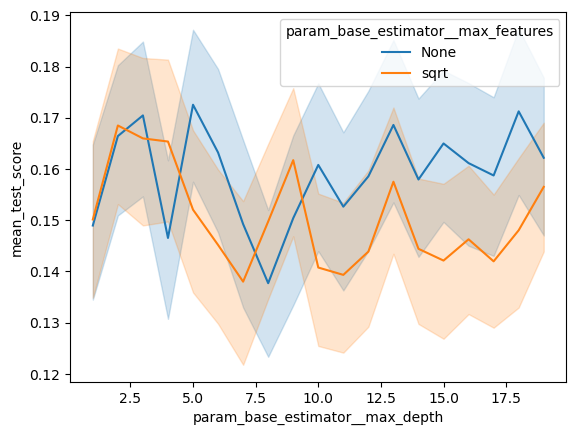

In [162]:
best_estimator = cv.best_estimator_
cv_results = pd.DataFrame(cv.cv_results_)
cv_results.loc[cv_results.param_base_estimator__class_weight != 'balanced', 'param_base_estimator__class_weight'] = 'None'
cv_results.loc[cv_results.param_base_estimator__max_features != 'sqrt', 'param_base_estimator__max_features'] = 'None'


sns.lineplot(
    # since all balanced outperforms None
    cv_results,
    x='param_base_estimator__max_depth',
    y='mean_test_score',
    hue='param_base_estimator__max_features',
#     hue='base_estimator__max_depth',
)


In [34]:
1 - y_train.mean()

0.8731172980374258

In [35]:
1 - y_test.mean()

0.8740875912408759

In [169]:

print(
    'F1 Scores:\n',
    'train score:', f1_score(best_estimator.predict(X_train), y_train), '\n',
    'test score:', f1_score(best_estimator.predict(X_test), y_test),
)

print(
    'Accuracies:\n',
    'train score:', best_estimator.score(X_train, y_train), '\n',
    'test score:', best_estimator.score(X_test, y_test),
)

confusion_matrix(best_estimator.predict(X_train), y_train)

F1 Scores:
 train score: 0.5266821345707656 
 test score: 0.2752293577981651
Accuracies:
 train score: 0.8137836604290278 
 test score: 0.7116788321167883


array([[1556,   51],
       [ 357,  227]])

/opt/homebrew/Caskroom/miniforge/base/envs/assignment_1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


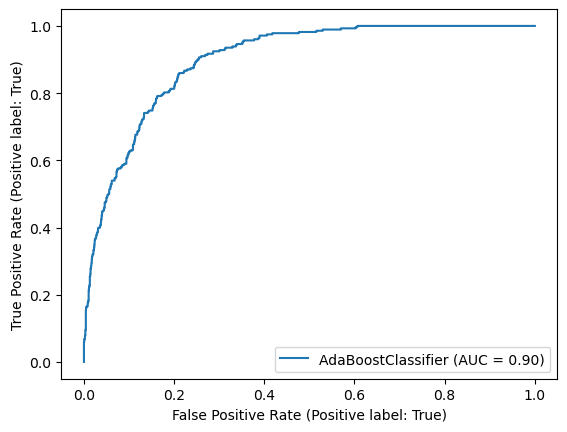

In [118]:
plot_roc_curve(best_estimator, X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/assignment_1/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


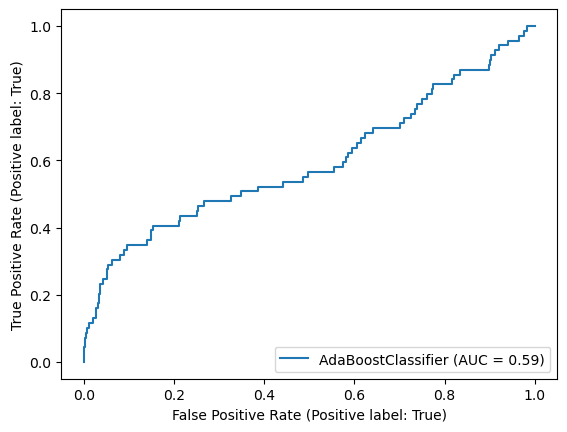

In [119]:
plot_roc_curve(best_estimator, X_test, y_test)